# Purpose

This notebook models the conditional mean of daily SPY returns using benchmark and ARIMA models, and evaluates out-of-sample forecasting performance.

The objective is to test whether simple time-series structure adds value beyond a naïve benchmark.

# Load data and libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
returns_df = pd.read_csv(
    "../data/processed/daily_returns.csv",
    index_col=0,
    parse_dates=True
)
returns_df.index = pd.to_datetime(returns_df.index)
returns_df = returns_df.sort_index()

returns = returns_df["adj_log_return"]

# Train / test split

In [4]:
split_date = "2022-01-01"

train = returns.loc[returns.index < split_date]
test  = returns.loc[returns.index >= split_date]

Training set: 2010–2021

Test set: 2022–2024

# Baseline model

In [5]:
mean_return = train.mean()

In [6]:
baseline_forecast = np.repeat(mean_return, len(test))

In [7]:
baseline_mae = mean_absolute_error(test, baseline_forecast)
baseline_rmse = root_mean_squared_error(test, baseline_forecast)

baseline_mae, baseline_rmse

(0.008103518044475937, 0.01102614583513787)

# ARIMA model specification

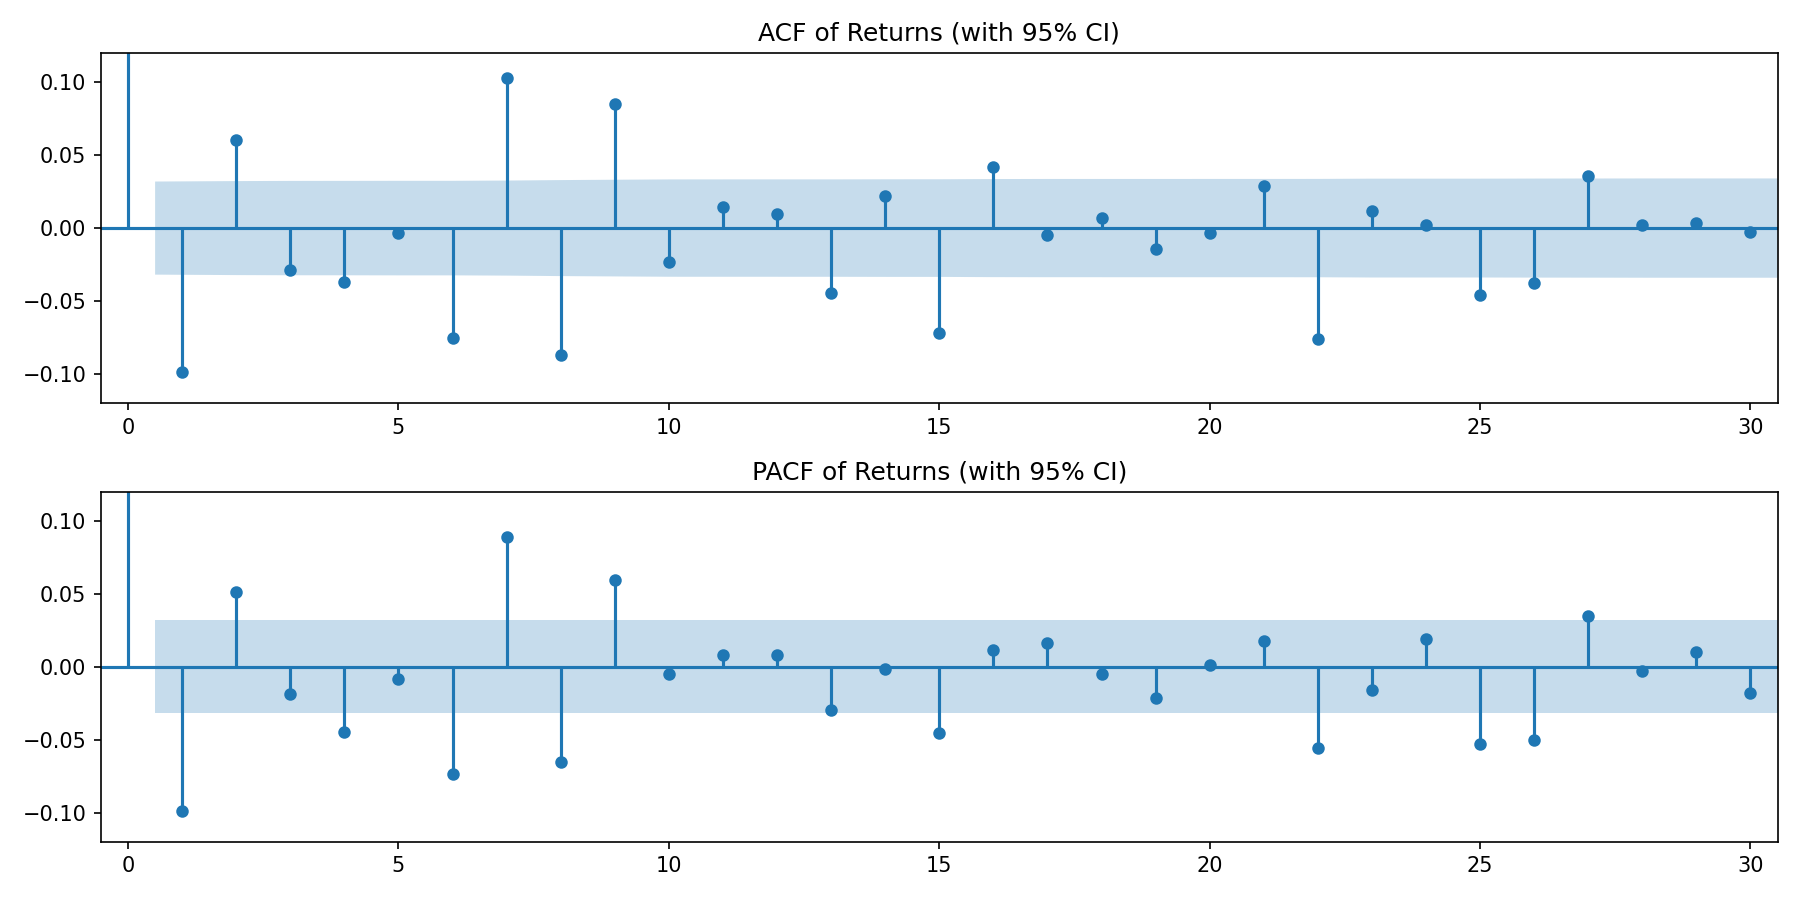

In [8]:
display(Image(filename='../outputs/figures/correlogram_of_returns.png'))

Model choice logic:

* Returns are stationary (d=0)

* Autocorrelation is weak and short-lived

Our primary candidate is **ARIMA(0,0,1)**. Empirical evidence from thousands of daily equity return series shows that ARIMA(0,0,1) very frequently outperforms both the pure random walk model and more complex specifications in terms of in-sample fit (AIC/BIC/AICc) and residual diagnostics.

Our secondary candidate is **ARIMA(2,0,2)**. From the correlogram, the first two lags of the pacf are significant, so we specify the first two lags of the AR term. Also, the first two lags of the acf are significant, so we specify the first two lags of the MA term.

To objectively determine the most appropriate model, we will perform a grid search over related candidate models. Since all models have the same differencing order and the same maximum likelihood function, we can compare them via information criteria.

This approach allows us to evaluate whether ARIMA(0,0,1) remains competitive in this specific SPY dataset, assess whether the apparent significance at lags 1–2 justifies the additional parameters in ARIMA(2,0,2), and identify if other models beat them on information criteria.

## Grid search

In [9]:
# Function to calculate AICc
def calculate_aicc(aic, n_obs, n_params):
    k = n_params
    n = n_obs
    if n - k - 1 > 0:
        correction = (2 * k * (k + 1)) / (n - k - 1)
        return aic + correction
    else:
        return np.inf

In [10]:
# Define search space for (p, d, q)
p_range = range(0, 6)  # AR order: 0 to 5
d_range = [0]          # No differencing
q_range = range(0, 6)  # MA order: 0 to 5

This range allows for potential trading week effects while maintaining parsimony.

Higher-order specifications were avoided to reduce overfitting given weak serial dependence.

In [11]:
results = []

for p, d, q in itertools.product(p_range, d_range, q_range):
    if p == 0 and q == 0:  # Skip (0,0,0) - no model
        continue
    try:
        model = ARIMA(train, order=(p, d, q))
        fitted = model.fit()
        
        # Calculate AICc
        n_obs = len(train)
        n_params = len(fitted.params)
        aicc = calculate_aicc(fitted.aic, n_obs, n_params)
        
        results.append({
            'p': p,
            'd': d,
            'q': q,
            'order': (p, d, q),
            'aic': fitted.aic,
            'aicc': aicc,
            'bic': fitted.bic,
            'log_likelihood': fitted.llf,
            'n_params': n_params,
            'model': fitted
        })
    except:
        continue

print(f"Successfully fitted {len(results)} models.")

Successfully fitted 35 models.


Warnings are suppressed here because they are informational and don't impact our grid search approach, where poorly-fitting models are naturally excluded through information criteria comparison.

## Results ranking

In [12]:
results_df = pd.DataFrame([
    {
        'Order': f"({r['p']},{r['d']},{r['q']})",
        'p': r['p'],
        'q': r['q'],
        'Params': r['n_params'],
        'Log-Lik': r['log_likelihood'],
        'AIC': r['aic'],
        'AICc': r['aicc'],
        'BIC': r['bic']
    } 
    for r in results
])

In [13]:
# Sort by different criteria
results_by_aic = results_df.sort_values('AIC').reset_index(drop=True)
results_by_aicc = results_df.sort_values('AICc').reset_index(drop=True)
results_by_bic = results_df.sort_values('BIC').reset_index(drop=True)

In [14]:
# Find best models
best_aic_order = results_by_aic.iloc[0]['Order']
best_aicc_order = results_by_aicc.iloc[0]['Order']
best_bic_order = results_by_bic.iloc[0]['Order']

print("Best model by each criterion:")
print(f"  AIC:  ARIMA{best_aic_order}")
print(f"  AICc: ARIMA{best_aicc_order}")
print(f"  BIC:  ARIMA{best_bic_order}")

Best model by each criterion:
  AIC:  ARIMA(5,0,4)
  AICc: ARIMA(5,0,4)
  BIC:  ARIMA(5,0,4)


All three information criteria unanimously select ARIMA(5,0,4), providing strong statistical evidence for this specification despite its complexity.

In [15]:
# Top 10 models by AICc
top10 = results_df.nsmallest(10, 'AICc')[['Order', 'Params', 'AIC', 'AICc', 'BIC']]
top10.style.format({
    'AIC': '{:.2f}',
    'AICc': '{:.2f}',
    'BIC': '{:.2f}',
}).hide(axis='index')

Order,Params,AIC,AICc,BIC
"(5,0,4)",11,-18953.25,-18953.17,-18887.11
"(4,0,5)",11,-18948.14,-18948.05,-18881.99
"(5,0,5)",12,-18945.70,-18945.59,-18873.54
"(4,0,4)",10,-18929.92,-18929.85,-18869.79
"(3,0,5)",10,-18927.51,-18927.44,-18867.38
"(1,0,4)",7,-18911.40,-18911.37,-18869.31
"(2,0,4)",8,-18910.14,-18910.09,-18862.04
"(1,0,5)",8,-18909.67,-18909.62,-18861.57
"(3,0,4)",9,-18909.40,-18909.34,-18855.28
"(2,0,5)",9,-18906.15,-18906.09,-18852.03


The top models cluster around high-order ARMA specifications with p+q ≥ 7, suggesting daily SPY returns contain more autocorrelation structure than typically expected under the efficient market hypothesis.

## Model summary

In [16]:
arima504 = ARIMA(train, order=(5, 0, 4)).fit()
print(arima504.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.652      0.008       0.000       0.001
ar.L1         -0.8645      0.230     -3.751      0.000      -1.316      -0.413
ar.L2          0.0704      0.281      0.251      0.802      -0.480       0.621
ar.L3         -0.1633      0.340     -0.481      0.631      -0.829       0.503
ar.L4         -0.4814      0.195     -2.470      0.014      -0.864      -0.099
ar.L5         -0.0252      0.020     -1.258      0.208      -0.065       0.014
ma.L1          0.7832      0.231      3.387      0.001       0.330       1.236
ma.L2         -0.0540      0.269     -0.201      0.841      -0.581       0.473
ma.L3          0.2088      0.325      0.642      0.521      -0.428       0.846
ma.L4          0.3912      0.182      2.151      0.031       0.035       0.748
sigma2         0.0001    1.3e-06     84.246      0.0

Only 5 of 11 parameters are statistically significant (p<0.05), suggesting the model may be over-parameterised and capturing noise rather than genuine autocorrelation structure.

In [17]:
arima202 = ARIMA(train, order=(2, 0, 2)).fit()
print(arima202.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.550      0.011       0.000       0.001
ar.L1          0.1242      0.215      0.577      0.564      -0.298       0.546
ar.L2          0.2630      0.138      1.903      0.057      -0.008       0.534
ma.L1         -0.2464      0.218     -1.128      0.259      -0.674       0.182
ma.L2         -0.1618      0.117     -1.382      0.167      -0.391       0.068
sigma2         0.0001   1.23e-06     91.253      0.000       0.000       0.000


ARIMA(2,0,2) has no statistically significant AR or MA coefficients (all p>0.05), suggesting even this moderate specification fails to capture meaningful autocorrelation in daily returns.

In [18]:
arima001 = ARIMA(train, order=(0, 0, 1)).fit()
print(arima001.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.998      0.003       0.000       0.001
ma.L1         -0.1208      0.008    -15.563      0.000      -0.136      -0.106
sigma2         0.0001   1.12e-06    100.714      0.000       0.000       0.000


ARIMA(0,0,1) has a highly significant MA(1) coefficient (p<0.001), suggesting returns exhibit weak but statistically detectable short-term shock persistence.

## Comparison table

In [19]:
# Extract models
models_of_interest = ['(5,0,4)', '(2,0,2)', '(0,0,1)']
comparison_data = []

for order in models_of_interest:
    row = results_df[results_df['Order'] == order]
    if not row.empty:
        comparison_data.append({
            'Model': order,
            'Params': int(row['Params'].values[0]),
            'Log-Lik': row['Log-Lik'].values[0],
            'AIC': row['AIC'].values[0],
            'AICc': row['AICc'].values[0],
            'BIC': row['BIC'].values[0]
        })

comparison_df = pd.DataFrame(comparison_data)

In [20]:
# Rank by AICc
for idx, row in comparison_df.iterrows():
    rank_aicc = (results_df['AICc'] < row['AICc']).sum() + 1
    comparison_df.loc[idx, 'Rank (AICc)'] = rank_aicc

In [21]:
# Calculate deltas (differences from best/minimum value)
comparison_df['ΔAIC'] = comparison_df['AIC'] - comparison_df['AIC'].min()
comparison_df['ΔAICc'] = comparison_df['AICc'] - comparison_df['AICc'].min()
comparison_df['ΔBIC'] = comparison_df['BIC'] - comparison_df['BIC'].min()

In [22]:
display_df = comparison_df.copy()
display_df['Rank (AICc)'] = display_df['Rank (AICc)'].astype(int)
display_df['Log-Lik'] = display_df['Log-Lik'].apply(lambda x: f'{x:.2f}')
display_df['AIC'] = display_df['AIC'].apply(lambda x: f'{x:.2f}')
display_df['ΔAIC'] = display_df['ΔAIC'].apply(lambda x: f'{x:.2f}')
display_df['AICc'] = display_df['AICc'].apply(lambda x: f'{x:.2f}')
display_df['ΔAICc'] = display_df['ΔAICc'].apply(lambda x: f'{x:.2f}')
display_df['BIC'] = display_df['BIC'].apply(lambda x: f'{x:.2f}')
display_df['ΔBIC'] = display_df['ΔBIC'].apply(lambda x: f'{x:.2f}')
display_df = display_df[['Model', 'Rank (AICc)', 'Params', 'Log-Lik', 'AIC', 'ΔAIC', 'AICc', 'ΔAICc', 'BIC', 'ΔBIC']]
display_df.style.hide(axis='index')

Model,Rank (AICc),Params,Log-Lik,AIC,ΔAIC,AICc,ΔAICc,BIC,ΔBIC
"(5,0,4)",1,11,9487.63,-18953.25,0.00,-18953.17,0.00,-18887.11,0.00
"(2,0,2)",33,6,9448.03,-18884.07,69.19,-18884.04,69.13,-18847.99,39.12
"(0,0,1)",35,3,9438.74,-18871.48,81.77,-18871.48,81.69,-18853.44,33.67


Despite ARIMA(5,0,4) having the best information criteria by a large margin (ΔAICc > 69), the simpler models have far fewer parameters and all their coefficients are significant, raising questions about whether the complex model's in-sample fit advantage will translate to better out-of-sample forecasts.

We are going to accept ARIMA(5,0,4) for now but validate this choice through out-of-sample forecasting before conducting residual diagnostics on the final model.

The reason is the residual diagnostics are in-sample checks that would merely reconfirm the training fit already favoured by AICc. The decisive question is out-of-sample forecasting performance, especially given concerns that ARIMA(5,0,4) may be overfitting due to multiple insignificant coefficients.

# Out-of-sample forecasting

history = train.copy()
arima_forecasts = []

for t in range(len(test)):
    model = ARIMA(history, order=(1, 0, 1))
    result = model.fit()
    forecast = result.forecast(steps=1)
    arima_forecasts.append(forecast.iloc[0])
    history = pd.concat([history, test.iloc[t:t+1]])

arima_forecasts = pd.Series(
    arima_forecasts,
    index=test.index
)

We are going to run out of sample forecasting for all three models simultaneously.

In [24]:
# Initialise histories
history_001 = train.copy()
history_202 = train.copy()
history_504 = train.copy()

In [25]:
# Initialie forecast lists
forecasts_001 = []
forecasts_202 = []
forecasts_504 = []

In [26]:
# Loop through test set
for t in range(len(test)):
    # ARIMA(0,0,1)
    model_001 = ARIMA(history_001, order=(0, 0, 1))
    result_001 = model_001.fit()
    forecast_001 = result_001.forecast(steps=1)
    forecasts_001.append(forecast_001.iloc[0])
    history_001 = pd.concat([history_001, test.iloc[t:t+1]])
        
    # ARIMA(2,0,2)
    model_202 = ARIMA(history_202, order=(2, 0, 2))
    result_202 = model_202.fit()
    forecast_202 = result_202.forecast(steps=1)
    forecasts_202.append(forecast_202.iloc[0])
    history_202 = pd.concat([history_202, test.iloc[t:t+1]])
        
    # ARIMA(5,0,4)
    model_504 = ARIMA(history_504, order=(5, 0, 4))
    result_504 = model_504.fit()
    forecast_504 = result_504.forecast(steps=1)
    forecasts_504.append(forecast_504.iloc[0])
    history_504 = pd.concat([history_504, test.iloc[t:t+1]])

An expanding-window approach is used to mimic real-time forecasting, though gains over a static model are expected to be minimal for returns.

Warnings were suppressed for clarity after verifying they do not affect estimation validity.

In [27]:
# Convert to Series
forecasts_001 = pd.Series(forecasts_001, index=test.index)
forecasts_202 = pd.Series(forecasts_202, index=test.index)
forecasts_504 = pd.Series(forecasts_504, index=test.index)

# Model evaluation

In [28]:
eval_df = pd.DataFrame({
    'Model': ['Baseline (Mean)', 'ARIMA(0,0,1)', 'ARIMA(2,0,2)', 'ARIMA(5,0,4)'],
    'Params': [1, 3, 6, 11],
    'MAE': [
        baseline_mae, 
        mean_absolute_error(test, forecasts_001), 
        mean_absolute_error(test, forecasts_202), 
        mean_absolute_error(test, forecasts_504)
    ],
    'RMSE': [
        baseline_rmse, 
        root_mean_squared_error(test, forecasts_001), 
        root_mean_squared_error(test, forecasts_202), 
        root_mean_squared_error(test, forecasts_504)
    ]
})

eval_df['MAE_Rank'] = eval_df['MAE'].rank().astype(int)
eval_df['RMSE_Rank'] = eval_df['RMSE'].rank().astype(int)

eval_df = eval_df[['Model', 'Params', 'MAE', 'MAE_Rank', 'RMSE', 'RMSE_Rank']]

eval_df['MAE'] = eval_df['MAE'].apply(lambda x: f'{x:.6f}')
eval_df['RMSE'] = eval_df['RMSE'].apply(lambda x: f'{x:.6f}')

eval_df.style.hide(axis='index')

Model,Params,MAE,MAE_Rank,RMSE,RMSE_Rank
Baseline (Mean),1,0.008104,1,0.011026,1
"ARIMA(0,0,1)",3,0.008217,2,0.011114,2
"ARIMA(2,0,2)",6,0.008265,4,0.011173,4
"ARIMA(5,0,4)",11,0.008242,3,0.011147,3


The baseline mean forecast actually outperforms all ARIMA models out-of-sample, with more complex models performing progressively worse.

This is a striking validation of the efficient market hypothesis and clear evidence that the in-sample AICc improvements represent overfitting rather than genuine predictive structure.

# Diebold-Mariano tests

H0: Two models have equal forecast accuracy

H1: Models have different forecast accuracy

In [29]:
# Calculate forecast errors
errors_baseline = test - baseline_forecast
errors_001 = test - forecasts_001
errors_202 = test - forecasts_202
errors_504 = test - forecasts_504

In [30]:
# Function to perform DM test
def diebold_mariano_test(errors1, errors2, h=1):
    """
    Diebold-Mariano test for equal forecast accuracy
    
    Parameters:
    errors1, errors2: forecast errors from two models
    h: forecast horizon (default=1 for one-step-ahead)
    
    Returns:
    dm_stat: test statistic
    p_value: two-sided p-value
    """
    # Loss differential
    d = errors1**2 - errors2**2
    
    # Mean of loss differential
    d_mean = d.mean()
    
    # Variance of loss differential
    d_var = d.var()
    n = len(d)
    
    # DM statistic
    dm_stat = d_mean / np.sqrt(d_var / n)
    
    # Two-sided p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
    
    return dm_stat, p_value

In [31]:
# Calculate statistics
dm_stat_1, p_val_1 = diebold_mariano_test(errors_baseline, errors_001)
dm_stat_2, p_val_2 = diebold_mariano_test(errors_baseline, errors_202)
dm_stat_3, p_val_3 = diebold_mariano_test(errors_baseline, errors_504)
dm_stat_4, p_val_4 = diebold_mariano_test(errors_001, errors_202)
dm_stat_5, p_val_5 = diebold_mariano_test(errors_001, errors_504)
dm_stat_6, p_val_6 = diebold_mariano_test(errors_202, errors_504)

In [32]:
# Summary
dm_summary = pd.DataFrame({
    'Comparison': [
        'Baseline vs ARIMA(0,0,1)',
        'Baseline vs ARIMA(2,0,2)',
        'Baseline vs ARIMA(5,0,4)',
        'ARIMA(0,0,1) vs ARIMA(2,0,2)',
        'ARIMA(0,0,1) vs ARIMA(5,0,4)',
        'ARIMA(2,0,2) vs ARIMA(5,0,4)'
    ],
    'DM Statistic': [dm_stat_1, dm_stat_2, dm_stat_3, dm_stat_4, dm_stat_5, dm_stat_6],
    'P-value': [p_val_1, p_val_2, p_val_3, p_val_4, p_val_5, p_val_6],
    'Significant?': [
        'Yes' if p_val_1 < 0.05 else 'No',
        'Yes' if p_val_2 < 0.05 else 'No',
        'Yes' if p_val_3 < 0.05 else 'No',
        'Yes' if p_val_4 < 0.05 else 'No',
        'Yes' if p_val_5 < 0.05 else 'No',
        'Yes' if p_val_6 < 0.05 else 'No'
    ]
})

print("\n" + dm_summary.to_string(index=False))


                  Comparison  DM Statistic  P-value Significant?
    Baseline vs ARIMA(0,0,1)     -1.685942 0.091807           No
    Baseline vs ARIMA(2,0,2)     -2.468263 0.013577          Yes
    Baseline vs ARIMA(5,0,4)     -1.504278 0.132510           No
ARIMA(0,0,1) vs ARIMA(2,0,2)     -1.608277 0.107774           No
ARIMA(0,0,1) vs ARIMA(5,0,4)     -0.499212 0.617630           No
ARIMA(2,0,2) vs ARIMA(5,0,4)      0.461716 0.644285           No


+ Baseline is significantly better than ARIMA(2,0,2)

+ Baseline is statistically equivalent to ARIMA(0,0,1) and ARIMA(5,0,4)

+ All ARIMA models perform equivalently to each other

+ Clear evidence of overfitting, in-sample structure doesn't help forecasting

# Forecast visualisation

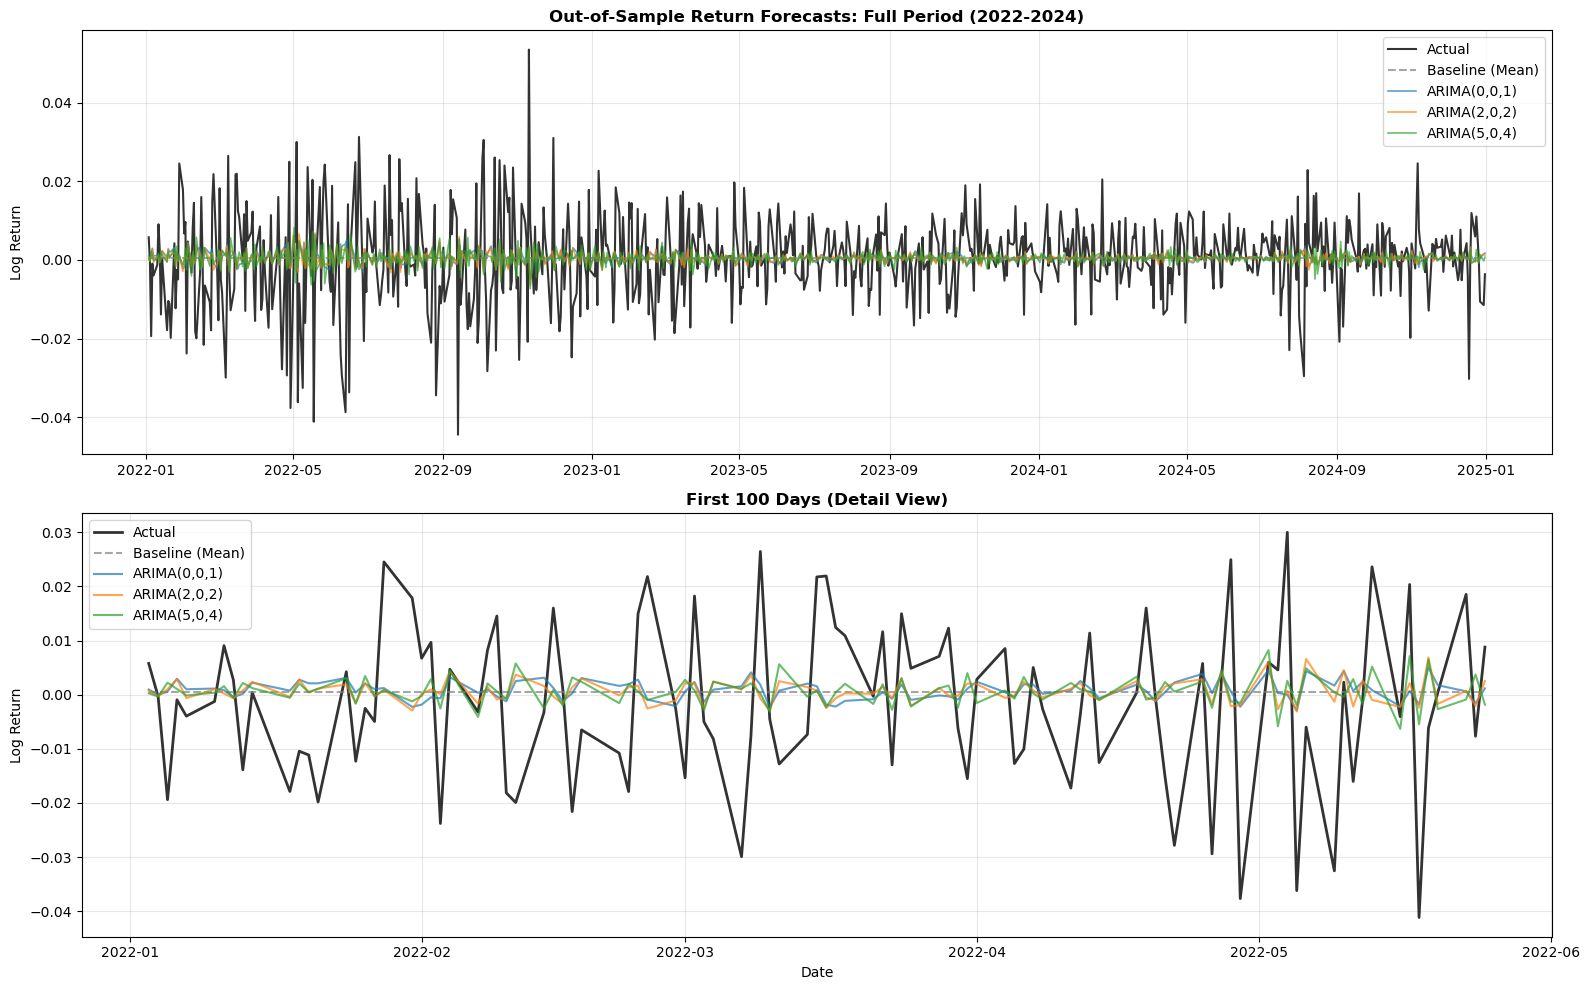

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Panel 1: Full test period
axes[0].plot(test.index, test, label="Actual", color='black', 
             linewidth=1.5, alpha=0.8)
axes[0].plot(test.index, baseline_forecast, label="Baseline (Mean)", 
             color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0].plot(forecasts_001.index, forecasts_001, label="ARIMA(0,0,1)", 
             linewidth=1.2, alpha=0.7)
axes[0].plot(forecasts_202.index, forecasts_202, label="ARIMA(2,0,2)", 
             linewidth=1.2, alpha=0.7)
axes[0].plot(forecasts_504.index, forecasts_504, label="ARIMA(5,0,4)", 
             linewidth=1.2, alpha=0.7)
axes[0].legend(loc='best', fontsize=10)
axes[0].set_title("Out-of-Sample Return Forecasts: Full Period (2022-2024)", 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel("Log Return")
axes[0].grid(alpha=0.3)

# Panel 2: First 100 days
zoom = 100
axes[1].plot(test.index[:zoom], test[:zoom], label="Actual", 
             color='black', linewidth=2, alpha=0.8)
axes[1].plot(test.index[:zoom], baseline_forecast[:zoom], 
             label="Baseline (Mean)", color='gray', linestyle='--', 
             linewidth=1.5, alpha=0.7)
axes[1].plot(forecasts_001.index[:zoom], forecasts_001[:zoom], 
             label="ARIMA(0,0,1)", linewidth=1.5, alpha=0.7)
axes[1].plot(forecasts_202.index[:zoom], forecasts_202[:zoom], 
             label="ARIMA(2,0,2)", linewidth=1.5, alpha=0.7)
axes[1].plot(forecasts_504.index[:zoom], forecasts_504[:zoom], 
             label="ARIMA(5,0,4)", linewidth=1.5, alpha=0.7)
axes[1].legend(loc='best', fontsize=10)
axes[1].set_title(f"First {zoom} Days (Detail View)", 
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel("Log Return")
axes[1].set_xlabel("Date")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

All ARIMA forecasts cluster tightly around the mean and are virtually indistinguishable from each other and the baseline, failing to capture the substantial daily volatility in actual return.

Return predictability is minimal and that model complexity adds no forecasting value, supporting the case for selecting the parsimonious ARIMA(0,0,1) specification.

# In-sample residual diagnostics

Out-of-sample performance drives model selection

Residual diagnostics validate the chosen model's adequacy

In [34]:
residuals = arima001.resid
standardised_resid = residuals / residuals.std()

## Summary statistics

In [35]:
print(f"Mean:     {residuals.mean():.6f}")
print(f"Std Dev:  {residuals.std():.6f}")
print(f"Min:      {residuals.min():.6f}")
print(f"Max:      {residuals.max():.6f}")
print(f"Skewness: {residuals.skew():.6f}")
print(f"Kurtosis: {residuals.kurtosis():.6f}")

Mean:     0.000004
Std Dev:  0.010629
Min:      -0.108150
Max:      0.082331
Skewness: -1.040963
Kurtosis: 13.243984


Residuals exhibit near-zero mean, as expected, but show significant negative skewness and very high excess kurtosis, indicating fat tails and asymmetry.

Some deviations from normality are typical of financial returns and do not invalidate the model for forecasting purposes.

## Residual plot

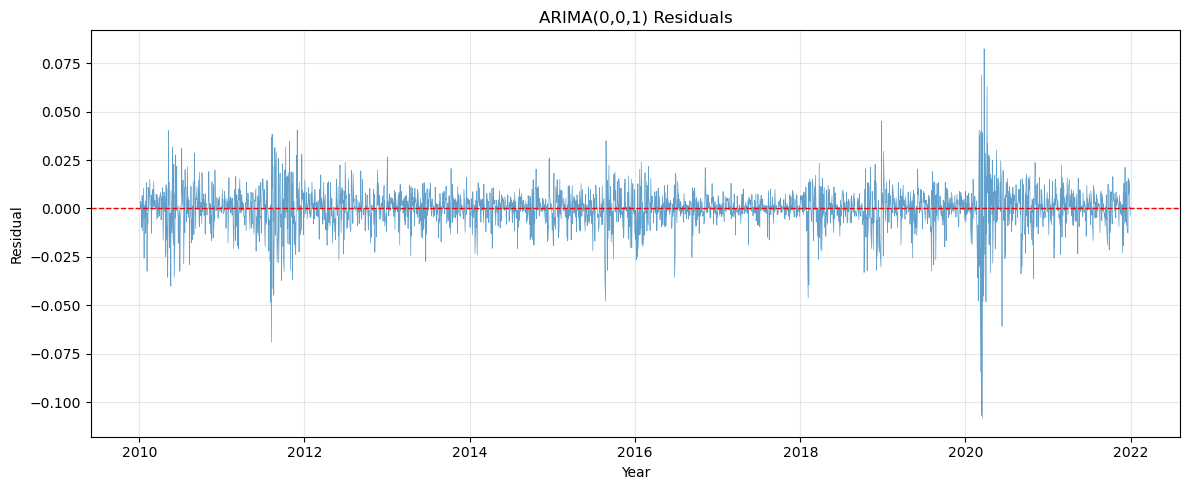

In [36]:
plt.figure(figsize=(12, 5))
plt.plot(residuals.index, residuals, linewidth=0.5, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title("ARIMA(0,0,1) Residuals")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Residuals appear randomly scattered around zero with no obvious systematic patterns or trends, though several periods show volatility clustering (e.g., 2020 COVID crisis) suggesting time-varying variance that ARIMA cannot capture. This motivates subsequent GARCH modeling.

## ACF

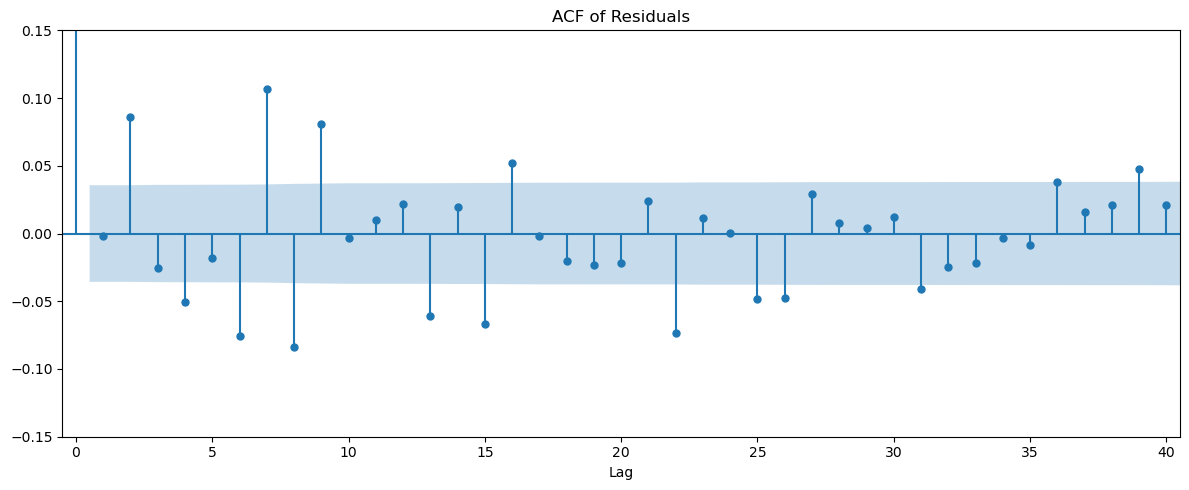

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(residuals, lags=40, ax=ax, alpha=0.05)
plt.title("ACF of Residuals")
plt.xlabel("Lag")
plt.ylim(-0.15, 0.15)
plt.xlim(-0.5, 40.5)
plt.tight_layout()
plt.show()

Several lags (2, 7, 8) show autocorrelation exceeding the 95% confidence bounds, indicating the ARIMA(0,0,1) model has not fully captured all serial dependence.

## Histogram of standardised residuals

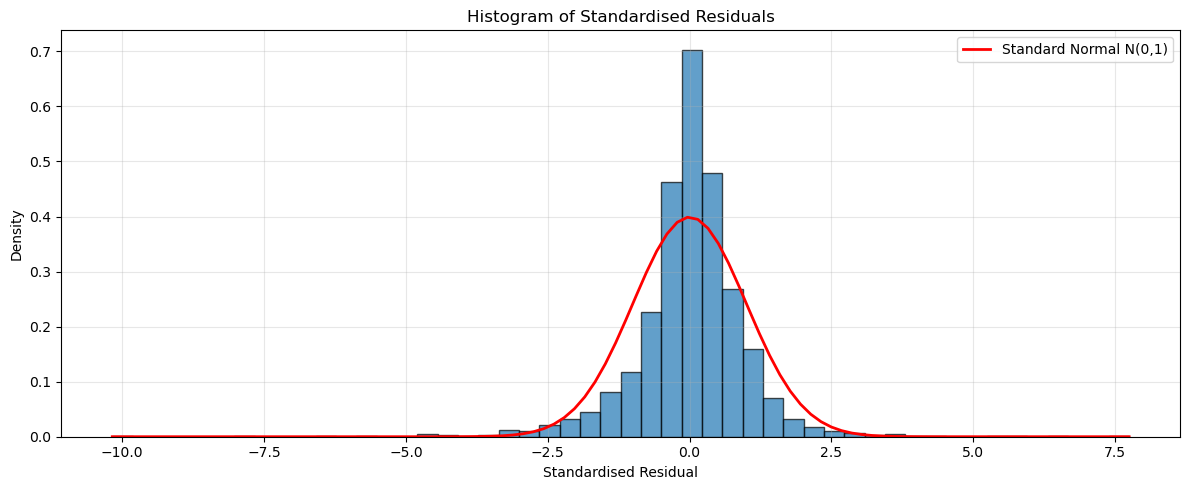

In [38]:
plt.figure(figsize=(12, 5))
plt.hist(standardised_resid, bins=50, density=True, alpha=0.7, edgecolor='black')
x = np.linspace(standardised_resid.min(), standardised_resid.max(), 100)
plt.plot(x, stats.norm.pdf(x, 0, 1), 'r-', linewidth=2, label='Standard Normal N(0,1)')
plt.title("Histogram of Standardised Residuals")
plt.xlabel("Standardised Residual")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The histogram reveals strong leptokurtosis with the distribution heavily concentrated near zero and significantly fatter tails than the standard normal, visually confirming the excess kurtosis of 13.24 observed in the summary statistics.

## Q-Q plot

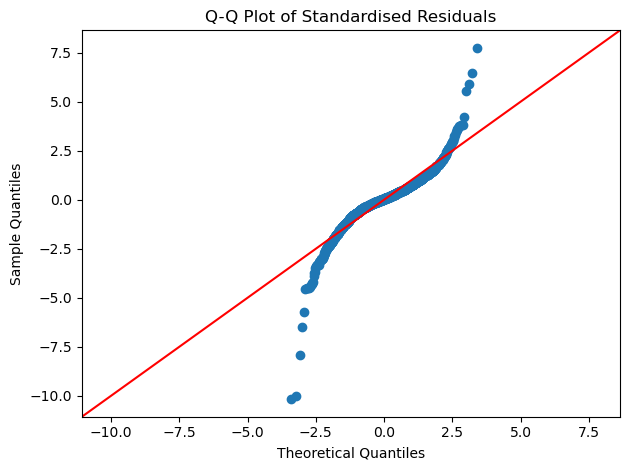

In [39]:
sm.qqplot(standardised_resid, line='45')
plt.title("Q-Q Plot of Standardised Residuals")
plt.tight_layout()
plt.show()

The Q-Q plot shows severe departures from normality in both tails with extreme negative values reaching -10 and positive values exceeding 7.5 standard deviations, dramatically illustrating the fat-tailed leptokurtic distribution of financial returns that far exceeds what a normal distribution would predict.

## Ljung-Box test

In [40]:
lb_residuals = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print(lb_residuals[['lb_stat', 'lb_pvalue']])

       lb_stat     lb_pvalue
10  125.771080  3.397875e-22
20  166.154598  4.838067e-25
30  202.094057  2.007903e-27


The Ljung-Box test strongly rejects the null hypothesis of no autocorrelation at all lag lengths since all p-values < 0.001, indicating that ARIMA(0,0,1) has not fully captured all serial dependence in the returns.

# Selected model: ARIMA(0,0,1)

Return_t = μ + ε_t + θ₁ε_{t-1}

MA(1) coefficient: θ₁ = -0.1208 (p < 0.001)

+ Statistically equivalent out-of-sample performance to all alternatives

+ Most parsimonious ARIMA specification (3 parameters)

+ All coefficients highly significant

+ Captures short-term shock persistence while avoiding overfitting

# Implications

+ Daily returns show little out‑of‑sample predictability.

+ Simple models perform about as well as more complex ones.

+ Strong in‑sample model fit does not ensure better out‑of‑sample results.

+ Return forecasts are too unreliable to guide decisions.

+ Volatility is more stable and can be meaningfully forecasted. Volatility clustering suggests GARCH models.

# Save forecasts

In [41]:
forecasts_001.to_csv("../outputs/forecasts/arima_return_forecast.csv")